# Apply of the CRISP-DM data mining methodology to analyse the data

In this notebook we're going to apply the steps of the CRISP-DM data mining methodology to analyse the data

The dataset we choose for this project: Stackoverflow. Link: https://demo.neo4jlabs.com:7473/browser/?dbms=neo4j://stackoverflow@demo.neo4jlabs.com&db=stackoverflow

# Installing necessary libraries

In [2]:
!pip install py2neo pandas
!pip install py2neo pandas matplotlib

# Loading necessary libraries

In [45]:
from py2neo import Graph
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Section-1: Loading the database into our local neo4j database
In this section, at first, we created a local database into our Neo4j Desktop named: stackoverflowdb. We choose the db version: 4.1.0

Then apply the following credentials to connnect to our local database:

In [46]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "87651234")) 

After that, we applied the following 7 queries one by one, in order to copy the live data into our local databae.
The link of the live database: https://demo.neo4jlabs.com:7473/browser/?dbms=neo4j://stackoverflow@demo.neo4jlabs.com&db=stackoverflow

In [8]:
query = """
WITH "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q

MERGE (question:Question {id:q.question_id})
  ON CREATE SET question.title = q.title, question.share_link = q.share_link, question.favorite_count = q.favorite_count, question.creation_date = q.creation_date
"""
graph.run(query).to_data_frame()

""


In [9]:
query = """
WITH "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id: q.question_id})
MERGE (owner:User {id:q.owner.user_id})
  ON CREATE SET owner.display_name = q.owner.display_name
MERGE (owner)-[:ASKED]->(question)
"""
graph.run(query).to_data_frame()

""


In [10]:
query = """
WITH "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id: q.question_id})

FOREACH (tagName IN q.tags | MERGE (tag:Tag {name:tagName}) MERGE (question)-[:TAGGED]->(tag))
FOREACH (a IN q.answers |
   MERGE (question)<-[:ANSWERED]-(answer:Answer {id:a.answer_id})
   MERGE (answerer:User {id:a.owner.user_id}) ON CREATE SET answerer.display_name = a.owner.display_name
   MERGE (answer)<-[:PROVIDED]-(answerer)
)
"""
graph.run(query).to_data_frame()

""


Create Constraints: Let's create some constraints to make sure we don't import duplicate data:

In [11]:
display(graph.run("CREATE CONSTRAINT on (q:Question) ASSERT q.id IS UNIQUE;").stats())
display(graph.run("CREATE CONSTRAINT on (t:Tag) ASSERT t.name IS UNIQUE;").stats())
display(graph.run("CREATE CONSTRAINT on (u:User) ASSERT u.id IS UNIQUE;").stats())

{'constraints_added': 1}

{'constraints_added': 1}

{'constraints_added': 1}

Larger import (10 Pages)

In [ ]:
query = """
UNWIND range(1,10) as page
WITH "https://api.stackexchange.com/2.2/questions?page="+page+"&pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q

MERGE (question:Question {id:q.question_id})
  ON CREATE SET question.title = q.title, question.share_link = q.share_link, question.favorite_count = q.favorite_count, question.creation_date = q.creation_date
"""
graph.run(query).to_data_frame()

In [ ]:
query = """
UNWIND range(1,10) as page
WITH "https://api.stackexchange.com/2.2/questions?page="+page+"&pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id:q.question_id})

MERGE (owner:User {id:coalesce(q.owner.user_id,'deleted')})
  ON CREATE SET owner.display_name = q.owner.display_name
MERGE (owner)-[:ASKED]->(question)
"""
graph.run(query).to_data_frame()

In [ ]:
query = """
UNWIND range(1,10) as page
WITH "https://api.stackexchange.com/2.2/questions?page="+page+"&pagesize=100&order=desc&sort=creation&tagged=neo4j&site=stackoverflow&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf" AS url
CALL apoc.load.json(url) YIELD value

UNWIND value.items AS q
MATCH (question:Question {id:q.question_id})

FOREACH (tagName IN q.tags | MERGE (tag:Tag {name:tagName}) MERGE (question)-[:TAGGED]->(tag))
FOREACH (a IN q.answers |
   MERGE (question)<-[:ANSWERED]-(answer:Answer {id:a.answer_id})
   MERGE (answerer:User {id:coalesce(a.owner.user_id,'deleted')}) ON CREATE SET answerer.display_name = a.owner.display_name
   MERGE (answer)<-[:PROVIDED]-(answerer)
)
"""
graph.run(query).to_data_frame()

# Section-2: EDA

Schema visualization

In [47]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('Answer', constraints=[], indexes=[], name='Answer'),
   Node('User', constraints=["Constraint( id=6, name='constraint_47e7f15d', type='UNIQUENESS', schema=(:User {id}), ownedIndex=5 )"], indexes=[], name='User'),
   Node('Question', constraints=["Constraint( id=2, name='constraint_f06c84a5', type='UNIQUENESS', schema=(:Question {id}), ownedIndex=1 )"], indexes=[], name='Question'),
   Node('Tag', constraints=["Constraint( id=4, name='constraint_64b1b1cf', type='UNIQUENESS', schema=(:Tag {name}), ownedIndex=3 )"], indexes=[], name='Tag')],
  'relationships': [TAGGED(Node(), Node()),
   ASKED(Node(), Node()),
   ANSWERED(Node(), Node()),
   PROVIDED(Node(), Node())]}]

No of nodes per label

In [54]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Tag,395
1,User,795
3,Answer,883
0,Question,998


Visualization using matplotlib

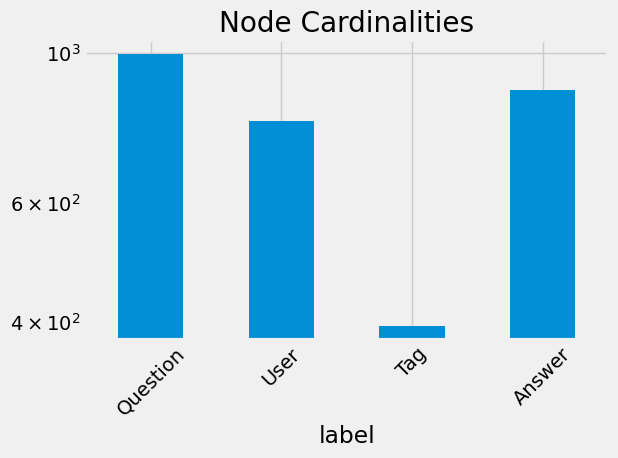

In [55]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

List of types of relationships

In [56]:
result = {"Relationship Type": [], "Count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as Count"
    count = graph.run(query).to_data_frame().iloc[0]['Count']
    result["Relationship Type"].append(relationship_type)
    result["Count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("Count")


,Relationship Type,Count
2,ANSWERED,883
3,PROVIDED,883
0,ASKED,995
1,TAGGED,2836


Visualization of the Relationship count result

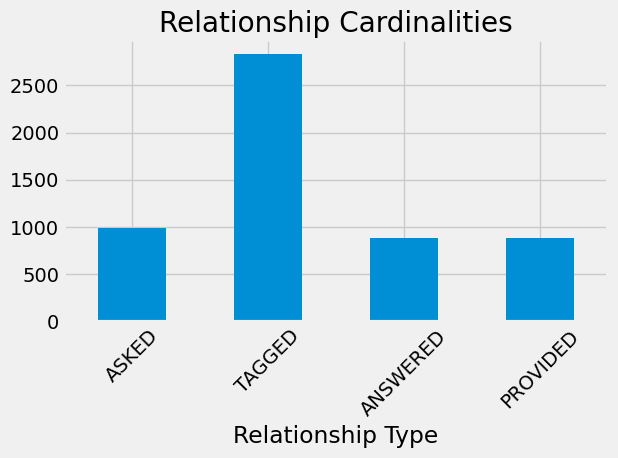

In [57]:
rels_df.plot(kind='bar', x='Relationship Type', y='Count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

List of labels

In [71]:
query = """ MATCH (n) RETURN labels(n) as Label, count(*) as Count; """
result = pd.DataFrame(graph.run(query).to_data_frame())
result_dict = {'Label': [], 'Count': []}
result['Label'] = [line for line in result['Label'].str[0]]
result['Count'] = [line for line in result['Count']]
result_df = pd.DataFrame(result)
result_df

,Label,Count
0,Question,998
1,User,795
2,Tag,395
3,Answer,883


Visualization of Label vs Count

<AxesSubplot: title={'center': 'Label vs Count'}, xlabel='Label'>

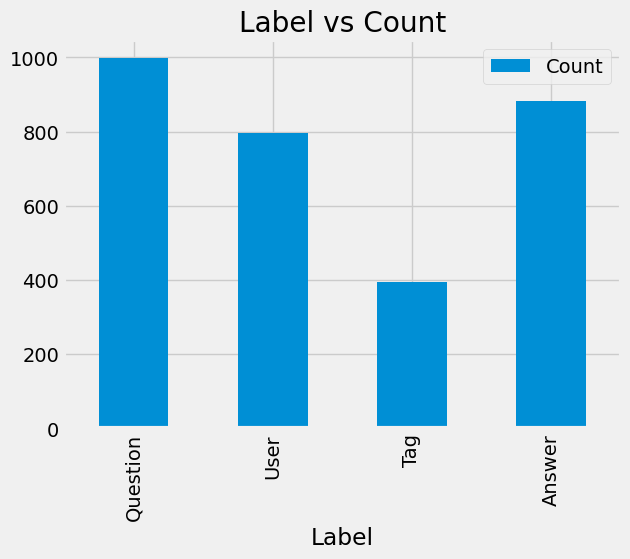

In [64]:
result_df.plot(x='Label', y='Count', kind='bar', title='Label vs Count')

Top 15 Tagged items and their counts

In [75]:
query = """ MATCH ()-[:TAGGED]->(t:Tag) RETURN t.name as `Tagged Name`,count(*) as Posts order by Posts desc limit 15;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tagged Name,Posts
0,neo4j,995
1,cypher,459
2,graph-databases,81
3,neo4j-apoc,77
4,python,65
5,spring-data-neo4j,57
6,java,46
7,database,40
8,graph,36
9,memgraphdb,27


Visualization of Tag vs Post

<AxesSubplot: title={'center': 'Tag vs Post'}, xlabel='Tagged Name'>

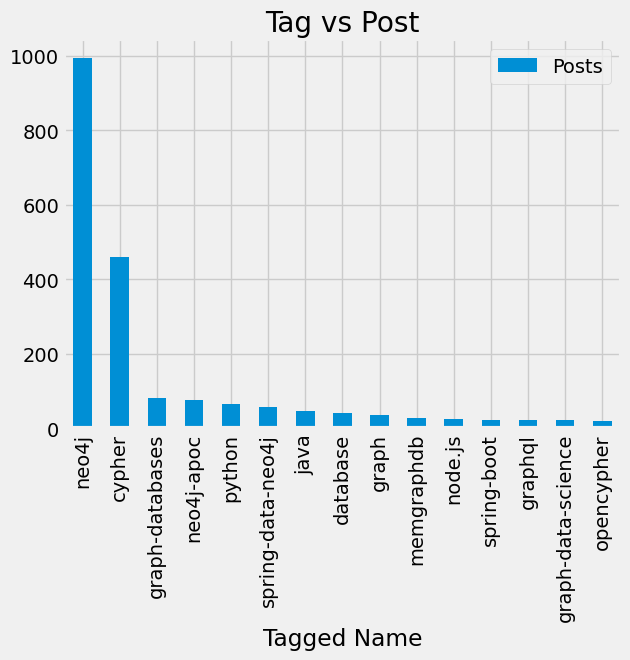

In [76]:
result.plot(x='Tagged Name', y='Posts', kind='bar', title='Tag vs Post')

Top ten users asking questions

In [78]:
query = """MATCH (User:User)-[:ASKED]->() RETURN User.display_name as Name, count(*) as Posts ORDER by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Posts
0,alexanoid,39
1,drdot,28
2,Vincenzo,10
3,le Minh Nguyen,10
4,JAMSHAID,9
5,SteveS,8
6,daylightisminetocommand,7
7,MichaelE,6
8,Lakeside52,6
9,Christos Grigoriadis,6


Visualiztion of Top ten users vs posts

<AxesSubplot: title={'center': 'User vs Posts'}, xlabel='Name'>

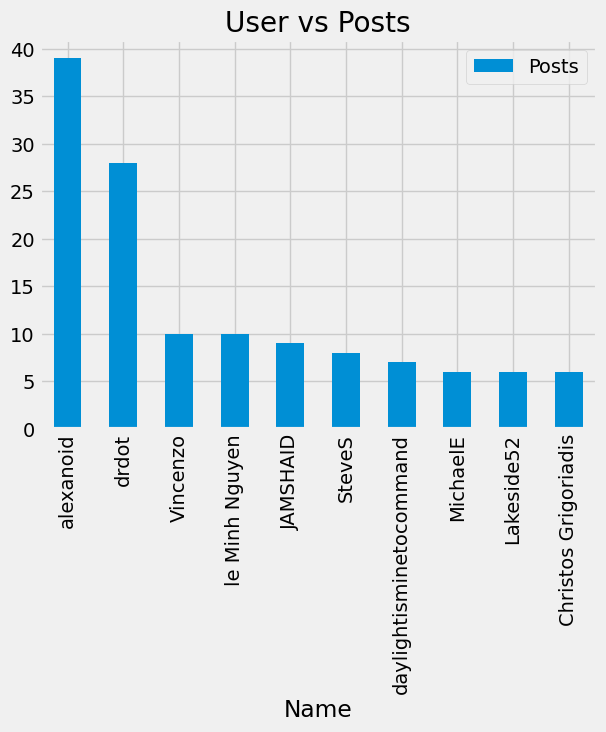

In [80]:
result.plot(x='Name', y='Posts', kind='bar', title='User vs Posts')

Top ten users answering

In [81]:
query = """MATCH (User:User)-[:PROVIDED]->() RETURN User.display_name as Name, count(*) as Posts ORDER by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Name,Posts
0,jose_bacoy,159
1,Charchit Kapoor,147
2,cybersam,66
3,Tomaž Bratanič,49
4,Graphileon,47
5,Michael Hunger,36
6,Christophe Willemsen,29
7,William Lyon,18
8,Vincent Rupp,14
9,nimrod serok,13


Visualization of top ten users answering posts

<AxesSubplot: title={'center': 'Top ten users answering posts'}, xlabel='Name'>

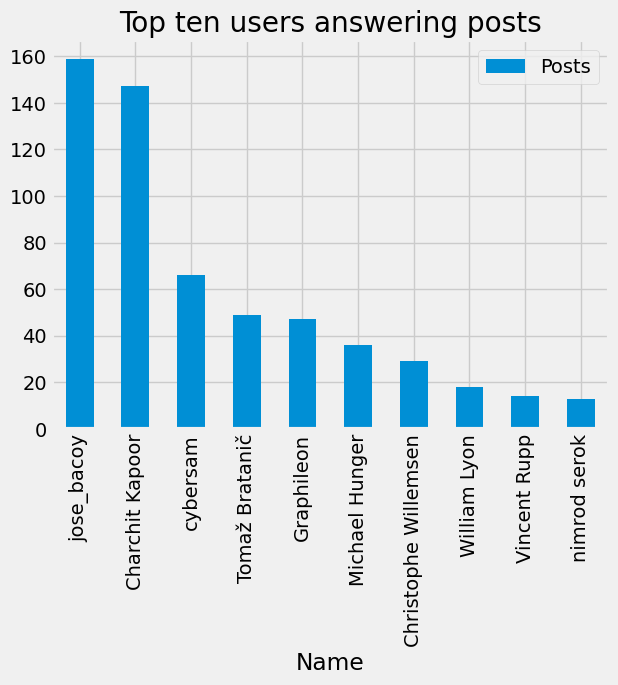

In [82]:
result.plot(x='Name', y='Posts', kind='bar', title='Top ten users answering posts')

Top days for answering questions

In [85]:
query = """MATCH (q:Question) RETURN apoc.date.format(q.creation_date,'s','EE') as Day, count(*) as Frequency ORDER BY Frequency desc;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Day,Frequency
0,Wed,181
1,Tue,179
2,Thu,169
3,Mon,156
4,Fri,128
5,Sun,100
6,Sat,85


Visualization of top ten days for answering questions

<AxesSubplot: title={'center': 'Top ten days for answering questions'}, xlabel='Day'>

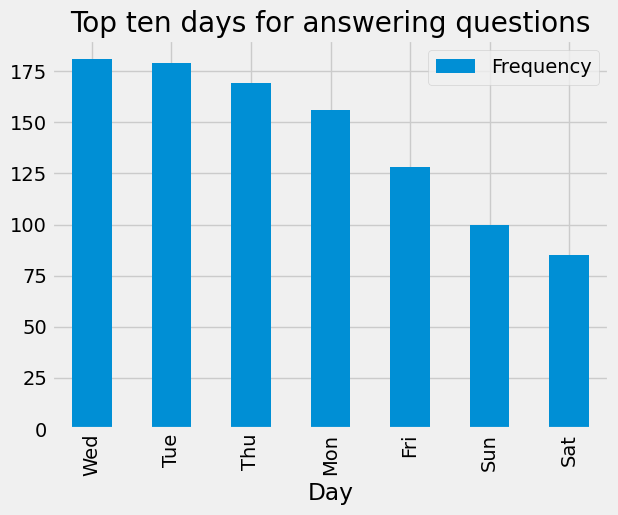

In [86]:
result.plot(x='Day', y='Frequency', kind='bar', title='Top ten days for answering questions')

Top ten tags for the user: "cybersam"

In [89]:
query = """MATCH (u:User)-[:PROVIDED]->()-[:ANSWERED]->()-[:TAGGED]->(t:Tag) WHERE u.display_name = "cybersam" RETURN t.name as `Tag`,count(*) as Posts order by Posts desc limit 10;"""
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tag,Posts
0,neo4j,66
1,cypher,41
2,opencypher,9
3,neo4j-apoc,8
4,memgraphdb,8
5,graph-databases,7
6,query-optimization,2
7,database,2
8,spring-data-neo4j,2
9,shortest-path,2


Visualization for top ten tags for the user: "cybersam"

<AxesSubplot: title={'center': 'Top ten tags for the user: "cybersam"'}, xlabel='Tag'>

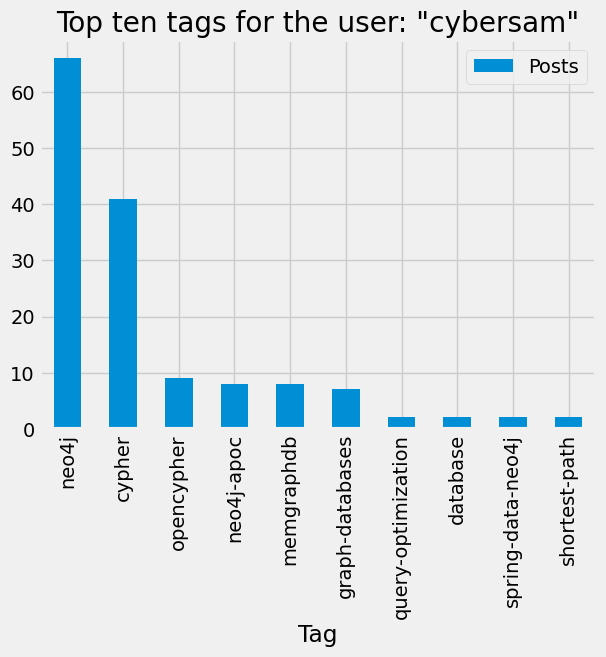

In [90]:
result.plot(x='Tag', y='Posts', kind='bar', title='Top ten tags for the user: "cybersam"')

Tags for unanswered questions

In [93]:
query = """MATCH (q:Question)-[:TAGGED]->(t:Tag) WHERE not t.name IN ['neo4j','cypher'] and not (q)<-[:ANSWERED]-() RETURN t.name as Tag, count(*) as Posts ORDER BY Posts desc LIMIT 10;""" 
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tag,Posts
0,spring-data-neo4j,23
1,java,23
2,graph-databases,20
3,python,19
4,spring-boot,15
5,database,14
6,spring,12
7,graphql,10
8,neo4j-apoc,10
9,spring-data,9


Visualization of tags for unanswered questions

<AxesSubplot: title={'center': 'Tags for unanswered questions'}, xlabel='Tag'>

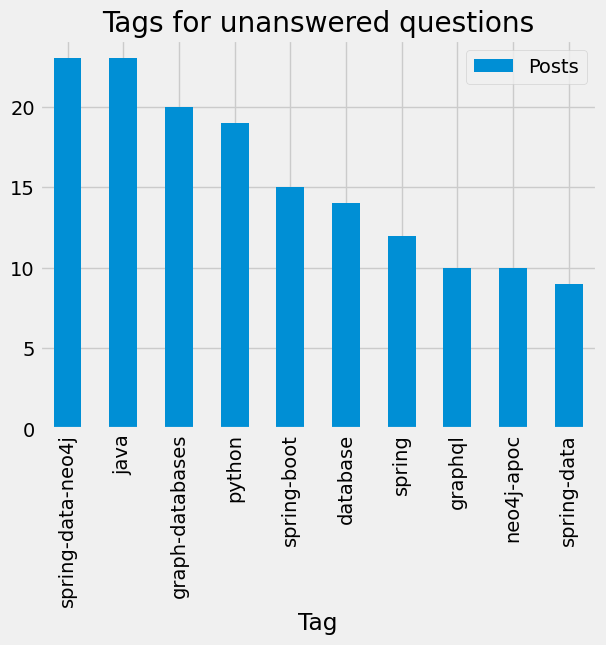

In [95]:
result.plot(x='Tag', y='Posts', kind='bar', title='Tags for unanswered questions')

Tag correlations

In [97]:
query = """MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag) WHERE id(t1) < id(t2) and t1.name <> 'neo4j' and t2.name <> 'neo4j' RETURN t1.name as `Tag-1`, t2.name as `Tag-2`,count(*) as Frequency ORDER BY Frequency desc LIMIT 10;""" 
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,Tag-1,Tag-2,Frequency
0,cypher,graph-databases,47
1,cypher,neo4j-apoc,44
2,memgraphdb,cypher,23
3,cypher,opencypher,18
4,cypher,graph,18
5,cypher,python,17
6,cypher,database,16
7,java,spring-data-neo4j,16
8,memgraphdb,opencypher,16
9,spring-data-neo4j,spring,14


User engagement for User "InverseFalcon"

In [105]:
query = """MATCH (t1:Tag)<-[:TAGGED]-()-[:TAGGED]->(t2:Tag)
WHERE id(t1) < id(t2) and t1.name <> 'neo4j' and t2.name <> 'neo4j'
WITH t1, t2,count(*) as freq  where freq > 3
RETURN t1,t2, apoc.create.vRelationship(t1,'OCCURRED',{freq:freq},t2) as rel;""" 
result = pd.DataFrame(graph.run(query).to_data_frame())
result

,t1,t2,rel
0,{'name': 'memgraphdb'},{'name': 'cypher'},{'freq': 23}
1,{'name': 'cypher'},{'name': 'neo4j-apoc'},{'freq': 44}
2,{'name': 'cypher'},{'name': 'neo4j-ogm'},{'freq': 5}
3,{'name': 'graphql'},{'name': 'neo4j-graphql-js'},{'freq': 10}
4,{'name': 'cypher'},{'name': 'database'},{'freq': 16}
5,{'name': 'cypher'},{'name': 'graph-theory'},{'freq': 8}
6,{'name': 'cypher'},{'name': 'java'},{'freq': 9}
7,{'name': 'neo4j-ogm'},{'name': 'spring-data-neo4j'},{'freq': 7}
8,{'name': 'java'},{'name': 'spring-data-neo4j'},{'freq': 16}
9,{'name': 'cypher'},{'name': 'spring-data-neo4j'},{'freq': 8}
